<a href="https://colab.research.google.com/github/Vulelale/.Net-backend-Skola/blob/master/Primena_XGBoost_algoritma_u_cilju_predvidjanja_aktivnosti_i_pona%C5%A1anja_korisnika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost


# Import biblioteka

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    mean_absolute_error,
    r2_score
)

# Import dataseta

In [ ]:

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Import dataseta

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Sredjivanje dataset-a

In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


df.drop('customerID', axis=1, inplace=True, errors='ignore')

print(df.columns)


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


# Definisanje promenljivih

In [ ]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

df = df[df['tenure'] > 0]

df['AnnualSpend'] = (df['TotalCharges'] / df['tenure']) * 12

df['BuyStreaming'] = df['StreamingMovies'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)


# Kodiranje kategorijalnih promenljivih

In [ ]:
cat_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(df_encoded.head())


   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  AnnualSpend  \
0              0       1           29.85         29.85      0   358.200000   
1              0      34           56.95       1889.50      0   666.882353   
2              0       2           53.85        108.15      1   648.900000   
3              0      45           42.30       1840.75      0   490.866667   
4              0       2           70.70        151.65      1   909.900000   

   BuyStreaming  gender_Male  Partner_Yes  Dependents_Yes  ...  \
0             0        False         True           False  ...   
1             0         True        False           False  ...   
2             0         True        False           False  ...   
3             0         True        False           False  ...   
4             0        False        False           False  ...   

   StreamingTV_No internet service  StreamingTV_Yes  \
0                            False            False   
1                       

# Model 1 - Formiranje ulaznih podataka za model retencije korisnika

In [ ]:
X = df_encoded.drop(
    ['Churn', 'AnnualSpend', 'BuyStreaming'],
    axis=1
)

y_churn = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y_churn, test_size=0.2, random_state=7,stratify=y_churn
)


# Model 1 - Trening modela

In [ ]:
churn_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight= (len(y_train) - y_train.sum()) / y_train.sum(),
    eval_metric='logloss',
    random_state=42
)


churn_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = churn_model.predict(X_test)
y_proba = churn_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.92      0.75      0.82      1033
           1       0.54      0.81      0.65       374

    accuracy                           0.77      1407
   macro avg       0.73      0.78      0.74      1407
weighted avg       0.82      0.77      0.78      1407

ROC AUC: 0.8643326379218412


# Model 1 - Prikaz retencije korisnika(random 5)

In [ ]:
show_random = X.sample(5).index

X_sample = X.loc[show_random]

actual_churn = df_encoded.loc[show_random, 'Churn']

predicted_churn = churn_model.predict(X_sample)

predicted_prob = churn_model.predict_proba(X_sample)[:, 1]

result_churn = pd.DataFrame({
    'Actual_Churn': actual_churn,
    'Predicted_Churn': predicted_churn,
    'Probability_of_Retention': predicted_prob.round(2)
})

result_churn


,Actual_Churn,Predicted_Churn,Probability_of_Retention
3515,0,0,0.34
2877,1,1,0.63
1345,0,0,0.48
6367,0,0,0.01
6783,0,0,0.05


# Model 2 - Formiranje ulaznih podataka za model godisnje potrosnje


In [ ]:
allowed_features_spend = [
    col for col in X.columns
    if (
        col.startswith('gender') or
        col.startswith('SeniorCitizen') or
        col.startswith('Partner') or
        col.startswith('Dependents') or
        col.startswith('tenure') or
        col.startswith('Contract') or
        col.startswith('PaperlessBilling') or
        col.startswith('PaymentMethod') or
        col.startswith('InternetService') or
        col.startswith('MultipleLines')
    )
]

X_spend = X[allowed_features_spend]
y_spend = df_encoded['AnnualSpend']

X_train, X_test, y_train, y_test = train_test_split(
    X_spend, y_spend, test_size=0.2, random_state=42
)


# Model 2 - Trening modela godisnje potrosnje

In [ ]:
spend_model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

spend_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
preds = spend_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, preds))
print("R2:", r2_score(y_test, preds))


MAE: 80.53137396410986
R2: 0.909552528489539


# Model 2 - Prikaz korisnika modela godisnje potrosnje


In [ ]:
show_random = X_spend.sample(5).index

X_sample = X_spend.loc[show_random]

actual_spend = df_encoded.loc[show_random, 'AnnualSpend']

predicted_spend = spend_model.predict(X_sample)

result_annual = pd.DataFrame({
    'Actual_Annual_Spend': actual_spend.round(2),
    'Predicted_Annual_Spend': predicted_spend.round(2),
    'Error': (actual_spend - predicted_spend).round(2)
})

result_annual


,Actual_Annual_Spend,Predicted_Annual_Spend,Error
6488,834.00,929.229980,-95.23
706,690.42,853.609985,-163.19
4696,1150.26,1166.670044,-16.41
6281,233.20,248.500000,-15.30
6127,1309.21,1198.180054,111.03


# Model 3 - Formiranje ulaznih podataka

In [ ]:
allowed_features = [
    col for col in X.columns
    if (
        col.startswith('gender') or
        col.startswith('SeniorCitizen') or
        col.startswith('Partner') or
        col.startswith('Dependents') or
        col.startswith('tenure') or
        col.startswith('Contract') or
        col.startswith('PaperlessBilling') or
        col.startswith('PaymentMethod')
    )
]

X_buy = X[allowed_features]


y_buy = df_encoded['BuyStreaming']

X_train, X_test, y_train, y_test = train_test_split(
    X_buy, y_buy, test_size=0.2, random_state=42
)


# Model 3 - procene kupovine


In [ ]:
buy_model = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.03,
    scale_pos_weight=1.6,
    eval_metric='logloss',
    random_state=42
)


buy_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = buy_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.63      0.70       877
           1       0.54      0.71      0.61       530

    accuracy                           0.66      1407
   macro avg       0.66      0.67      0.65      1407
weighted avg       0.69      0.66      0.66      1407



# Model 3 - Prikaz korisnika verovatnoce kupovine(random 5)


In [ ]:
sample_idx = X_buy.sample(5).index

X_sample = X_buy.loc[sample_idx]

actual_buy = df_encoded.loc[sample_idx, 'BuyStreaming']

predicted_buy = buy_model.predict(X_sample)

predicted_prob = buy_model.predict_proba(X_sample)[:, 1]

result_buy_df = pd.DataFrame({
    'Actual_BuyStreaming': actual_buy,
    'Predicted_BuyStreaming': predicted_buy,
    'Probability_of_Buying': predicted_prob.round(2)
})

result_buy_df


,Actual_BuyStreaming,Predicted_BuyStreaming,Probability_of_Buying
4679,1,1,0.85
872,0,0,0.44
2624,0,0,0.27
6046,1,0,0.45
644,0,1,0.56


# Model 3


In [ ]:
show_random = X.sample(5, random_state=43).index

#MODEL1
X_churn_sample = X.loc[show_random]
actual_churn = df_encoded.loc[show_random, 'Churn']
pred_churn = churn_model.predict(X_churn_sample)
prob_churn = churn_model.predict_proba(X_churn_sample)[:, 1]

#MODEL2
X_spend_sample = X_spend.loc[show_random]
actual_spend = df_encoded.loc[show_random, 'AnnualSpend']
pred_spend = spend_model.predict(X_spend_sample)

#MODEL3
X_buy_sample = X_buy.loc[show_random]
actual_buy = df_encoded.loc[show_random, 'BuyStreaming']
pred_buy = buy_model.predict(X_buy_sample)
prob_buy = buy_model.predict_proba(X_buy_sample)[:, 1]

#SPOJ U JEDNU TABELU
customer = pd.DataFrame({
    'Actual_Churn': actual_churn,
    'Predicted_Churn': pred_churn,
    'Probability_of_Retention': prob_churn.round(2),

    'Actual_Annual_Spend': actual_spend.round(2),
    'Predicted_Annual_Spend': pred_spend.round(2),

    'Actual_BuyStreaming': actual_buy,
    'Predicted_BuyStreaming': pred_buy,
    'Buy_Probability': prob_buy.round(2)
})

customer


,Actual_Churn,Predicted_Churn,Probability_of_Retention,Actual_Annual_Spend,Predicted_Annual_Spend,Actual_BuyStreaming,Predicted_BuyStreaming,Buy_Probability
3940,0,0,0.32,295.80,423.730011,0,0,0.41
3346,0,1,0.92,1116.30,992.530029,1,0,0.40
143,0,0,0.08,991.70,1228.239990,0,1,0.70
4204,0,1,0.84,980.40,972.890015,1,1,0.54
4386,1,0,0.10,664.67,781.690002,0,0,0.40


# Prikaz podataka koje je algoritam najvise shvatao bitnim


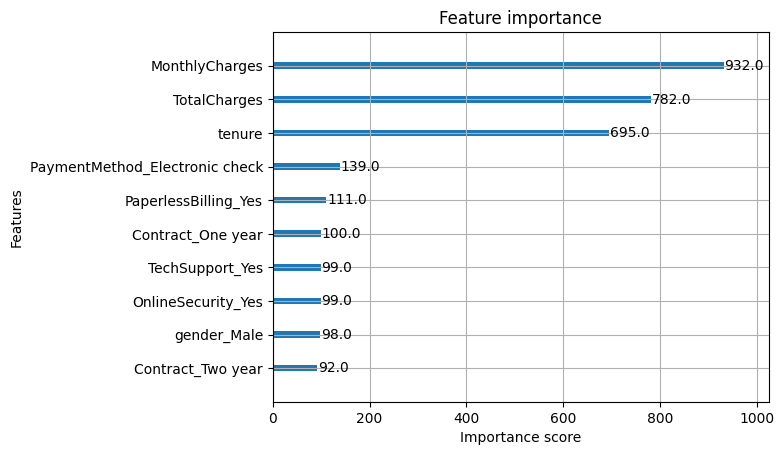

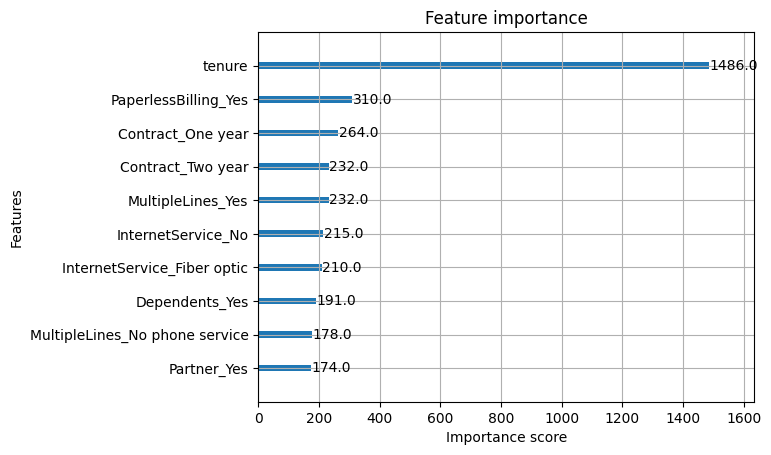

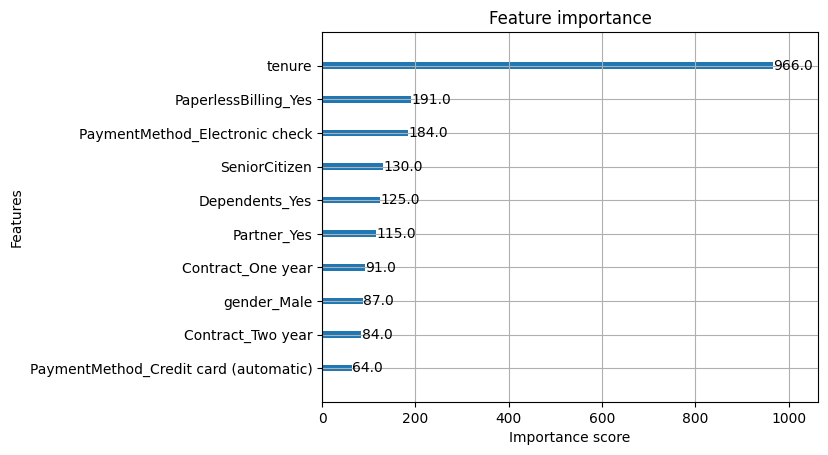

In [ ]:
from xgboost import plot_importance

#MODEL 1
plot_importance(churn_model, max_num_features=10)
plt.show()

#MODEL 2
plot_importance(spend_model, max_num_features=10)
plt.show()

#MODEL 3
plot_importance(buy_model, max_num_features=10)
plt.show()